In [28]:
import yfinance as yf
import pandas as pd
from fredapi import Fred
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_asset_data(tickers, start_date, end_date):
    """
    Load historical price data for specified tickers using yfinance.
    """
    return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Load macroeconomic data
def load_macro_data(api_key, indicators, start_date, end_date):
    """
    Load macroeconomic data from FRED API.
    """
    fred = Fred(api_key=api_key)
    macro_data = {}
    for indicator, name in indicators.items():
        macro_data[name] = fred.get_series(indicator, start_date, end_date)
    return pd.DataFrame(macro_data)


def get_api_key(file_path):
    """
    Retrieve API key from a text file.
    
    Args:
        file_path (str): Path to the file containing the API key.
        
    Returns:
        str: The API key.
    """
    try:
        with open(file_path, 'r') as file:
            api_key = file.read().strip()  # Read and remove any leading/trailing whitespace
        return api_key
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"Error: An unexpected error occurred - {e}")


In [29]:
# Get API key
api_key_path = "./api_key.txt"
fred_api_key = get_api_key(api_key_path)

if fred_api_key:
    print("API Key retrieved successfully.")
else:
    print("Failed to retrieve API Key.")

API Key retrieved successfully.


In [37]:
# Fetching historical price data for assets like SPY (stocks), TLT (bonds), and GLD (gold).
# Need market data for analyzing asset behavior (returns, volatility, covariance).
tickers = ['SPY', 'TLT', 'GLD']
start_date = '1900-01-01'
end_date = '2023-12-31'

# Loading key indicators like interest rates (FEDFUNDS) and CPI (inflation) to incorporate external market conditions.
asset_data = load_asset_data(tickers, start_date, end_date)
print("Asset Data Sample:")
display(asset_data.head())

# Fetch macro data
indicators = {
    'FEDFUNDS': 'Interest Rate',
    'CPIAUCSL': 'CPI'
}
macro_data = load_macro_data(fred_api_key, indicators, start_date, end_date)
print("Macro Data Sample:")
display(macro_data.head())


[*********************100%***********************]  3 of 3 completed

Asset Data Sample:


Ticker,GLD,SPY,TLT
Date,,,
1993-01-29,NaN,24.608635,NaN
1993-02-01,NaN,24.783655,NaN
1993-02-02,NaN,24.836163,NaN
1993-02-03,NaN,25.098682,NaN
1993-02-04,NaN,25.203712,NaN


Macro Data Sample:


,Interest Rate,CPI
1947-01-01,NaN,21.48
1947-02-01,NaN,21.62
1947-03-01,NaN,22.00
1947-04-01,NaN,22.00
1947-05-01,NaN,21.95


# Portfolio Metrics
1. Expected Return: How much the portfolio is expected to grow annually.
2. Volatility: The risk (uncertainty) in the portfolio’s returns.
3. Sharpe Ratio: Measures risk-adjusted performance (how much return you get per unit of risk).
4. Sortino Ratio: Focuses on downside risk (penalizes only negative returns).
5. Covariance Matrix: Shows how assets move relative to each other, helping us understand diversification benefits.


# Intuition
High diversified portfolio achieves higher returns for lower risk. Metrics like the Sharpe and Sortino ratios helps us figure out whether the portfolio is efficiently using risk to generate returns.

In [43]:
def calculate_portfolio_metrics(returns, weights):
    """
    Calculate key portfolio metrics: expected return, volatility, Sharpe ratio, Sortino ratio.
    """
    annualized_return = np.dot(weights, returns.mean()) * 252
    cov_matrix = returns.cov() * 252  # Annualized covariance matrix
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Sharpe Ratio
    risk_free_rate = 0.03  # can adjust later
    sharpe_ratio = (annualized_return - risk_free_rate) / portfolio_volatility

    # Sortino Ratio (downside risk)
    downside_returns = returns[returns < 0]
    downside_volatility = np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov() * 252, weights)))
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility

    return {
        "Annualized Return": annualized_return,
        "Volatility": portfolio_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Covariance Matrix": cov_matrix,
    }

# Calculate returns and metrics
returns = asset_data.pct_change().dropna()
weights = np.array([0.6, 0.3, 0.1])  # can adjust portfolio weights later
metrics = calculate_portfolio_metrics(returns, weights)

# Display metrics
print("Portfolio Metrics:")
for k, v in metrics.items():
    if k == "Covariance Matrix":
        print(f"\n{k}:\n")
        display(v)
    else:
        print(f"{k}: {v:.4f}")


Portfolio Metrics:
Annualized Return: 0.0932
Volatility: 0.1238
Sharpe Ratio: 0.5108
Sortino Ratio: 0.5989

Covariance Matrix:



Ticker,GLD,SPY,TLT
Ticker,,,
GLD,0.031155,0.001705,0.004287
SPY,0.001705,0.037114,-0.009587
TLT,0.004287,-0.009587,0.021933


# Monte Carlo Simulation

In [40]:
def monte_carlo_simulation(returns, weights, num_simulations=1000, num_days=252):
    """
    Simulate portfolio returns using Monte Carlo methods.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    simulations = []
    for _ in range(num_simulations):
        daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        portfolio_returns = np.dot(daily_returns, weights)
        portfolio_value = (1 + portfolio_returns).cumprod()
        simulations.append(portfolio_value)

    return np.array(simulations)

# Run simulation
simulated_paths = monte_carlo_simulation(returns, weights)
print(f"Generated {len(simulated_paths)} Monte Carlo simulations.")


Generated 1000 Monte Carlo simulations.


Covariance Matrix Heatmap:


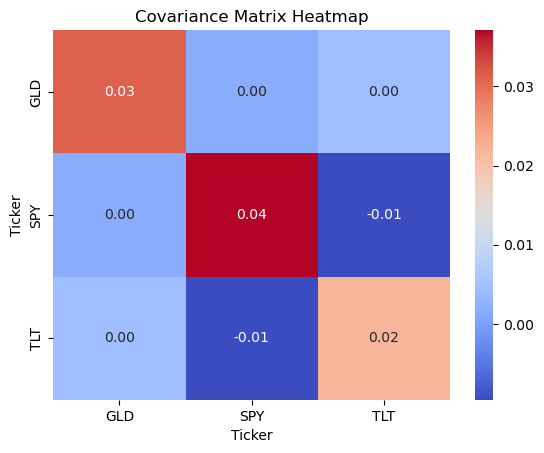

Monte Carlo Simulation Paths:


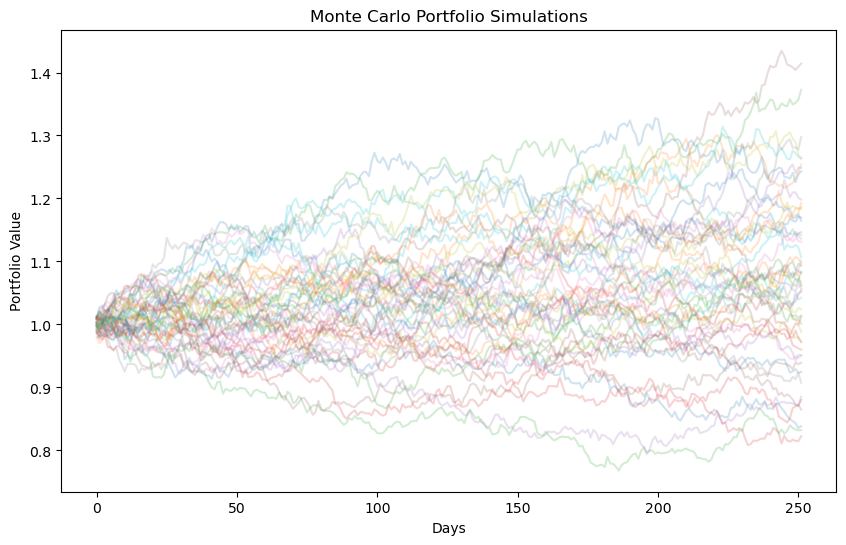

In [44]:
def plot_covariance_matrix(cov_matrix):
    """
    Plot a heatmap of the covariance matrix.
    """
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Covariance Matrix Heatmap")
    plt.show()

def plot_monte_carlo(simulations):
    """
    Plot Monte Carlo simulation paths.
    """
    plt.figure(figsize=(10, 6))
    for path in simulations[:50]:  # just plot a subset
        plt.plot(path, alpha=0.2)
    plt.title("Monte Carlo Portfolio Simulations")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value")
    plt.show()

print("Covariance Matrix Heatmap:")
plot_covariance_matrix(metrics["Covariance Matrix"])

print("Monte Carlo Simulation Paths:")
plot_monte_carlo(simulated_paths)


Covariance Matrix Heatmap:


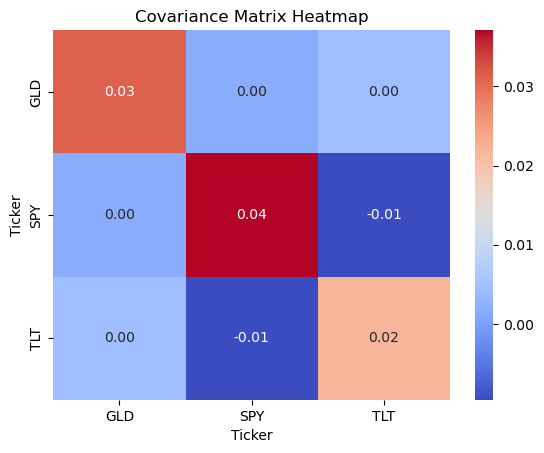

Monte Carlo Simulation Paths:


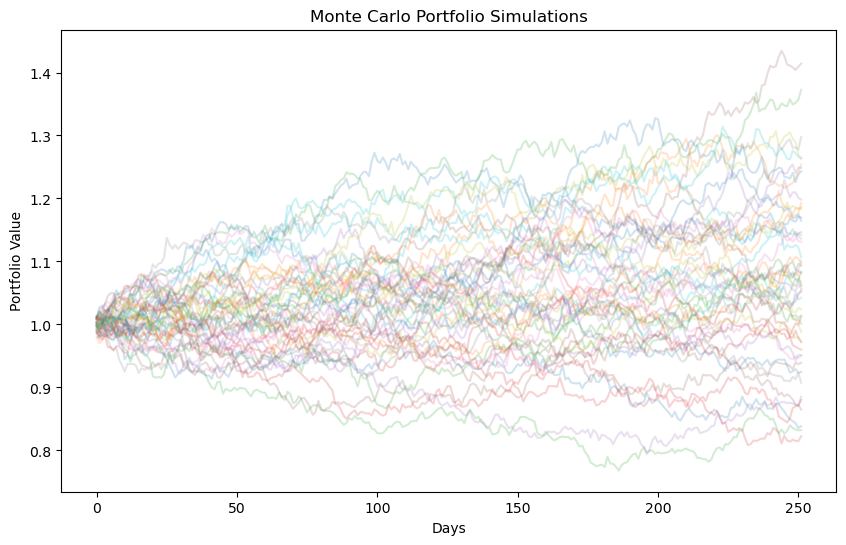

In [45]:
def plot_covariance_matrix(cov_matrix):
    """
    Plot a heatmap of the covariance matrix.
    """
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Covariance Matrix Heatmap")
    plt.show()

def plot_monte_carlo(simulations):
    """
    Plot Monte Carlo simulation paths.
    """
    plt.figure(figsize=(10, 6))
    for path in simulations[:50]:  # just plot a subset
        plt.plot(path, alpha=0.2)
    plt.title("Monte Carlo Portfolio Simulations")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value")
    plt.show()

# Plot results
print("Covariance Matrix Heatmap:")
plot_covariance_matrix(metrics["Covariance Matrix"])

print("Monte Carlo Simulation Paths:")
plot_monte_carlo(simulated_paths)


# Macro Data
Correlate macroeconomic data with asset returns.


Correlation Matrix:


C:\Users\hello\AppData\Local\Temp\ipykernel_10212\3401199883.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_data = macro_data.resample('M').mean()  # Resample to monthly frequency
C:\Users\hello\AppData\Local\Temp\ipykernel_10212\3401199883.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = returns.resample('M').sum()  # Convert to monthly returns


,GLD,SPY,TLT,Interest Rate,CPI
GLD,1.000000,0.087237,0.232779,0.102688,-0.071422
SPY,0.087237,1.000000,-0.101216,-0.036895,0.037595
TLT,0.232779,-0.101216,1.000000,0.013960,-0.094756
Interest Rate,0.102688,-0.036895,0.013960,1.000000,-0.029834
CPI,-0.071422,0.037595,-0.094756,-0.029834,1.000000


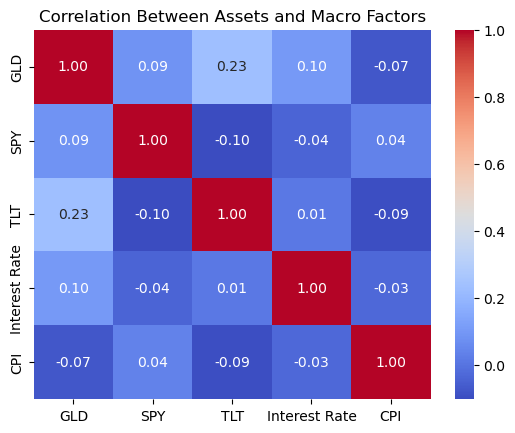

In [46]:
# merge macro data and asset returns for correlation analysis
macro_data = macro_data.resample('M').mean()  # Resample to monthly frequency
returns_monthly = returns.resample('M').sum()  # Convert to monthly returns
combined_data = returns_monthly.join(macro_data, how='inner')

# make correlation matrix
correlation = combined_data.corr()
print("Correlation Matrix:")
display(correlation)


sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Assets and Macro Factors")
plt.show()


In [ ]:
# Next 
# Add rolling metrics (e.g., rolling covariance).
# Integrate factor analysis (e.g., Fama-French models).
# Create an interactive dashboard with Streamlit